In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [1]:
import cv2
import glob
from skimage.transform import resize
from scipy import ndimage
from libs import utils 
import math


In [2]:
from fastai.vision import *

In [7]:
from keras.datasets import mnist


Using TensorFlow backend.


In [8]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshaping to format which CNN expects (batch, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1).astype(np.float32)

In [11]:
# AUX FUNCTIONS

# Some Preprocess
BINARY_THREHOLD = 180

def image_smoothening(img):
    ret1, th1 = cv2.threshold(img,BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

def remove_noise_and_smocoth_numpy(image_np):
    img = image_np.copy()

    img = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

    h,w = img.shape
    #img[img <128] = 0
    #img = img[int(w*0.2): int(w*0.9),int(h*0.2): int(h*0.9)] 

    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 41)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    
    #or_image = cv2.cvtColor(or_image, cv2.COLOR_GRAY2BGR)

    return or_image

def remove_red_color_numpy(image_np):
    
    img = image_np.copy()
    
    lower = np.array((90 - 60, 70, 50))  #-- Lower range --
    upper = np.array((90 + 60, 255, 255))  #-- Upper range 
    
    mask = cv2.inRange(img, lower, upper)
    
    res = cv2.bitwise_and(img, img, mask= mask)  #-- Contains pixels having the gray color--

    res = cv2.bitwise_not(res)
    
   
    return res

def convert_to_gray(image_np):
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    
    return image_gray

  
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

def remove_color_and_add_filter(numpy_i, test=False):
    
    img_or = remove_noise_and_smocoth_numpy(remove_red_color_numpy(numpy_i))
    img_or = cv2.resize(img_or,(60,60))
    #print(img.shape)

    o_w, o_h = img_or.shape
    #print(img.shape)

    img_or = 255.0 - img_or
    img = img_or.copy()

    try:
        while np.sum(img[0]) == 0:
            img = img[1:]
    except Exception as e:
        print(f"error {e}")
        return img_or
    try:
        while np.sum(img[:,0]) == 0:
            img = np.delete(img,0,1)
    except Exception as e:
        print(f"error {e}")
        return img_or
    try:
        while np.sum(img[-1]) == 0:
            img = img[:-1]
    except Exception as e:
        print(f"error {e}")
        return img_or
    try:
        while np.sum(img[:,-1]) == 0:
            img = np.delete(img,-1,1)
    except Exception as e:
        print(f"error {e}")
        return img

    rows,cols = img.shape
    if rows > cols:
        try:
            factor = 20.0/rows
            rows = 20
            cols = int(round(cols*factor))
            img = cv2.resize(img, (cols,rows))
        except Exception as e:
            print(f"error resizeing..{e}")
            return img_or
    else:
        try:
            factor = 20.0/cols
            cols = 20
            rows = int(round(rows*factor))
            img = cv2.resize(img, (cols, rows))
        except Exception as e:
            print(f"error resizeing..{e}")
            return img_or

    colsPadding = (int(math.ceil((24-cols)/2.0)),int(math.floor((24-cols)/2.0)))
    rowsPadding = (int(math.ceil((24-rows)/2.0)),int(math.floor((24-rows)/2.0)))

    img = np.lib.pad(img,(rowsPadding,colsPadding),'constant')

    img = np.lib.pad(img,(rowsPadding,colsPadding),"constant")

    shiftx,shifty = getBestShift(img)
    shifted = shift(img,shiftx,shifty)
    img = shifted

    if test:

        img_or_3c = numpy_i.copy()
        img_or_3c = cv2.resize(img_or_3c, (img.shape[1],img.shape[0]))
        gray = img.copy()

        img_n = np.zeros_like(img_or_3c)
        img_n[:,:,0] = gray
        img_n[:,:,1] = gray
        img_n[:,:,2] = gray

    return img

In [12]:

def load_dataset(image_label, image_directory, test=False):
    """
    Load jpg images form a given directory in a batch size format (B,W,H,C).
    Also create a list with the labels.
    
    Input:
    
    image_label:  ActivationString with the label for this data, e.g. "9", "0".
    image_directory: Strign with the full path to dir.
    
    Return:
    
    imgs_p:   Numpy array with the custom data.
    label_data: List with the labels
    """
    
    list_of_files = os.listdir(image_directory)
    
    # Placeholder for labels
    label_data = []
    
    # aux list for handle the file names
    files_path = []
    
    for file in list_of_files:
        image_file_name = os.path.join(image_directory, file)
        if ".jpg" in image_file_name:
            files_path.append(image_file_name)

            # Append the labels into the mnist labels
            #label_data = np.append(label_data, [image_label], axis=0)

            label_data.append(image_label)

    
    # Read every filename as an RGB image
    imgs = [plt.imread(fname)[..., :3] for fname in files_path]
        
    #print(imgs[0].shape)
    
    # Crop every image to a square
    imgs_or = [utils.imcrop_tosquare(img_i) for img_i in imgs]
    
    imgs_p = [resize(remove_color_and_add_filter(img_i, test), (28, 28, 3 if test else 1)) for img_i in imgs_or]
    
    # Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
    #
    imgs_p = np.array(imgs_p[:]).astype(np.float32)
    
    return imgs_p, label_data
    
# To load images to features and labels
def append_to_mnist(X_custom, y_custom, features_data, labels_data):
    """
    X_custom: Numpy array that represent the cusmtom dataset
    y_custom: List that represent the labels
    features_data: numpy array that represents the mnist features to augment.
    labels_data: numpy array that represents the mnist features to agument.
    
    return:
    features_data: Numpy array with the augmented custom data.
    label_data: numpy array with the augmented custom labels
    """
    # For load custom mnist data for augment some class
  
    # For features
    features_data = np.append(features_data, X_custom, axis=0)
    
    
    # For labels
    for label in y_custom:
        labels_data = np.append(labels_data, [label], axis=0)
    
    labels_data = labels_data.astype(np.float32)
    
    return features_data, labels_data


def augment_with_mnist(label, image_directory, X, y, test=False):
    """
    Augment the mnist with the custom mnist
    
    labels: String with the label for this data, e.g. "9", "0"
    image_directory: Strign with the full path to dir.
    
    X: numpy array that represents the mnist features to augment.
    y: numpy array that represents the mnist features to agument.
    
    return
    
    features_data: Numpy array with the augmented custom data.
    label_data: numpy array with the augmented custom labels.
    """
    
    imgs_custom, labels_custom = load_dataset(label, image_directory, test)
    
    features_data, label_data = append_to_mnist(imgs_custom, labels_custom, X, y)
    
    return features_data, label_data
    
    

In [76]:
def readCroppedImage(path, augmentations = True, test=True):
    
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    rgb_img = utils.imcrop_tosquare(bgr_img)

    rgb_img = resize(remove_color_and_add_filter(rgb_img, test), (28, 28, 3 if test else 1))

    # Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
    #
    rgb_img = np.array(rgb_img[:]).astype(np.float32)
    
    return rgb_img

In [29]:
%ls ../notebooks/

0/  1/  2/  3/  4/  5/  6/  7/  8/  9/  back/  trainData/


In [31]:
data_path = "../notebooks/"

In [22]:
labels = ["1","2","3", "4", "5", "6", "7", "8", "9", "0", "10"]


In [34]:

# create custom mnist dataset
imgs1, labels_1 = load_dataset("1", f'{data_path}/1', test=True)
imgs2, labels_2 = load_dataset("2", f'{data_path}/2', test=True)
imgs3, labels_3 = load_dataset("3", f'{data_path}/3', test=True)
imgs4, labels_4 = load_dataset("4", f'{data_path}/4', test=True)
imgs5, labels_5 = load_dataset("5", f'{data_path}/5', test=True)
imgs6, labels_6 = load_dataset("6", f'{data_path}/6', test=True)
imgs7, labels_7 = load_dataset("7", f'{data_path}/7', test=True)
imgs8, labels_8 = load_dataset("8", f'{data_path}/8', test=True)
imgs9, labels_9 = load_dataset("9", f'{data_path}/9', test=True)

In [51]:
imgs0, labels_0 = load_dataset("0", f'{data_path}/0', test=True)


error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0


In [52]:
imgs10, labels_10 = load_dataset("10", f'{data_path}/10', test=True)

error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of boun

error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error resizeing..OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3723: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 

In [47]:
def plot_grid(img):
    # Plot the resulting dataset:
    # Make sure you "run" this cell after you create your `imgs` variable as a 4-D array!
    # Make sure we have a 100 x 100 x 100 x 3 dimension array
    #assert(imgs.shape == (100, 100, 100, 3))
    print(img.shape)
    imgs_custom = img / 255.0
    plt.figure(figsize=(10, 10))
    plt.imshow(utils.montage(imgs_custom) )

In [50]:
paths = []
for folder in labels:
    print(folder)
    p = f"{data_path}/{folder}"
    paths.append(p)
    verify_images(p, delete=True, max_size=500)

In [53]:
np.random.seed(42)
data = ImageDataBunch.from_folder(data_path, train='.', 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  num_workers=4).normalize(imagenet_stats)

In [87]:
%ls dataset

In [54]:
data.classes

['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

In [56]:
data

ImageDataBunch;

Train: LabelList (2167 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
7,7,7,7,7
Path: ../notebooks;

Valid: LabelList (541 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,10,5,4,0
Path: ../notebooks;

Test: None

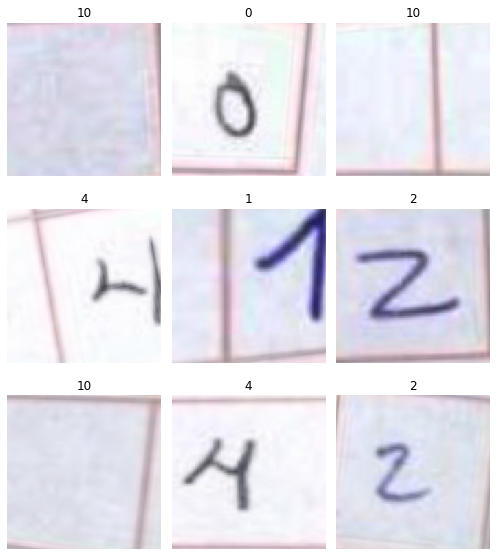

In [57]:
data.show_batch(rows=3, figsize=(7, 8))

In [ ]:
# Create fast ai data 

In [89]:
imgs_custom, labels_custom = load_dataset("1", f'{data_path}/1', test=True)


In [91]:
# create custom mnist dataset

for label in labels[1:]:
    imgs_custom, labels_custom =  augment_with_mnist(label,
                                                f'{data_path}/{label}',
                                                   imgs_custom,
                                                   labels_custom,test=True)

error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of boun

/home/stanley/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:1359: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error resizeing..OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3723: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 

In [93]:
import os

In [117]:
print(imgs_custom.shape)
print(labels_custom.shape)

(1827, 28, 28, 3)
(1827,)


In [94]:
%ls

dataset/  libs/  montage.png  Pixel_wise_ana.ipynb  test/  Untitled.ipynb


In [107]:
%rm -rf dataset

In [108]:
%mkdir dataset

In [109]:
%ls

dataset/  libs/  montage.png  Pixel_wise_ana.ipynb  test/  Untitled.ipynb


In [96]:
counter = 0

def save_images(img, label):
    global counter
    print(label)
    path =  f"./dataset/{int(label)}/"
    os.makedirs(path, exist_ok=True)
    
    cv2.imwrite(f"{path}/{counter}_{label}.jpg", img)
    counter +=1

for i,l in zip(imgs_custom, labels_custom):
    save_images(i,l)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0


In [105]:
np.random.seed(42)

data_path = "./dataset/"

data = ImageDataBunch.from_folder(data_path, train='.', 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  num_workers=4).normalize(imagenet_stats)

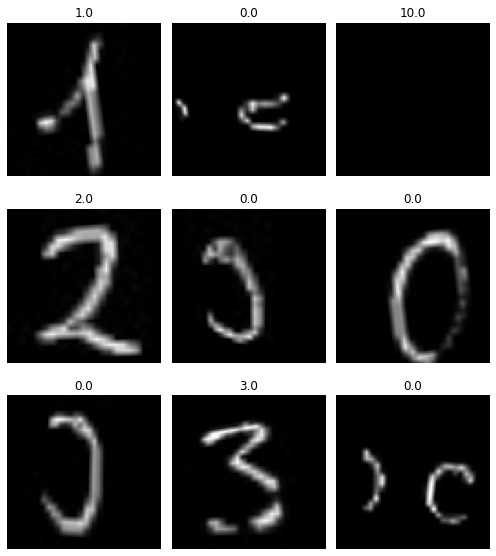

In [106]:
data.show_batch(rows=3, figsize=(7, 8))

In [110]:
# Create full dataset
print(labels)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '10']


In [115]:
%ls ../notebooks/trainData/

test/  train/


In [119]:
data_path = "../notebooks/trainData"

In [120]:
for i in labels:
    print(i)
    # Load your own images to training and test data
    X_train, y_train = augment_with_mnist(i, f'{data_path}/train/{i}', X_train, y_train)
    X_test, y_test = augment_with_mnist(i, f'{data_path}/test/{i}', X_test, y_test)

1
2
3
4
5
6
7
8
9
0
error index 0 is out of bounds for axis 0 with size 0
10
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error index 0 is out of bounds for axis 0 with size 0
error

In [123]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60701, 28, 28, 1)
(60701,)
(10180, 28, 28, 1)
(10180,)


In [124]:
X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test)

In [125]:
print(X.shape)
print(y.shape)

(70881, 28, 28, 1)
(70881,)


9.0


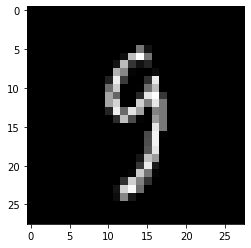

In [130]:
print(y[-50])
plt.imshow(X[-50][:,:,0], cmap="gray")

In [131]:
counter = 0

for im,la in zip(X, y):
    
    save_images(im,la)

5.0
0.0
4.0
1.0
9.0
2.0
1.0
3.0
1.0
4.0
3.0
5.0
3.0
6.0
1.0
7.0
2.0
8.0
6.0
9.0
4.0
0.0
9.0
1.0
1.0
2.0
4.0
3.0
2.0
7.0
3.0
8.0
6.0
9.0
0.0
5.0
6.0
0.0
7.0
6.0
1.0
8.0
7.0
9.0
3.0
9.0
8.0
5.0
9.0
3.0
3.0
0.0
7.0
4.0
9.0
8.0
0.0
9.0
4.0
1.0
4.0
4.0
6.0
0.0
4.0
5.0
6.0
1.0
0.0
0.0
1.0
7.0
1.0
6.0
3.0
0.0
2.0
1.0
1.0
7.0
9.0
0.0
2.0
6.0
7.0
8.0
3.0
9.0
0.0
4.0
6.0
7.0
4.0
6.0
8.0
0.0
7.0
8.0
3.0
1.0
5.0
7.0
1.0
7.0
1.0
1.0
6.0
3.0
0.0
2.0
9.0
3.0
1.0
1.0
0.0
4.0
9.0
2.0
0.0
0.0
2.0
0.0
2.0
7.0
1.0
8.0
6.0
4.0
1.0
6.0
3.0
4.0
5.0
9.0
1.0
3.0
3.0
8.0
5.0
4.0
7.0
7.0
4.0
2.0
8.0
5.0
8.0
6.0
7.0
3.0
4.0
6.0
1.0
9.0
9.0
6.0
0.0
3.0
7.0
2.0
8.0
2.0
9.0
4.0
4.0
6.0
4.0
9.0
7.0
0.0
9.0
2.0
9.0
5.0
1.0
5.0
9.0
1.0
2.0
3.0
2.0
3.0
5.0
9.0
1.0
7.0
6.0
2.0
8.0
2.0
2.0
5.0
0.0
7.0
4.0
9.0
7.0
8.0
3.0
2.0
1.0
1.0
8.0
3.0
6.0
1.0
0.0
3.0
1.0
0.0
0.0
1.0
7.0
2.0
7.0
3.0
0.0
4.0
6.0
5.0
2.0
6.0
4.0
7.0
1.0
8.0
9.0
9.0
3.0
0.0
7.0
1.0
0.0
2.0
0.0
3.0
5.0
4.0
6.0
5.0
8.0
6.0
3.0
7.0
5.0
8.0
0.0
9.0
1.0
0.0


3.0
5.0
4.0
3.0
8.0
8.0
8.0
0.0
7.0
0.0
4.0
5.0
9.0
4.0
0.0
3.0
6.0
4.0
0.0
1.0
9.0
5.0
6.0
3.0
4.0
0.0
2.0
8.0
2.0
3.0
1.0
0.0
4.0
6.0
7.0
2.0
0.0
7.0
2.0
1.0
4.0
1.0
6.0
8.0
7.0
1.0
8.0
7.0
4.0
1.0
0.0
3.0
6.0
8.0
4.0
4.0
3.0
2.0
9.0
0.0
8.0
9.0
9.0
7.0
2.0
6.0
7.0
7.0
5.0
4.0
3.0
1.0
3.0
6.0
1.0
8.0
9.0
4.0
8.0
1.0
6.0
2.0
8.0
6.0
5.0
7.0
9.0
1.0
6.0
9.0
6.0
8.0
0.0
0.0
0.0
6.0
7.0
9.0
7.0
4.0
9.0
9.0
9.0
9.0
7.0
6.0
7.0
2.0
8.0
3.0
6.0
7.0
9.0
1.0
7.0
2.0
1.0
5.0
1.0
3.0
7.0
7.0
0.0
8.0
6.0
0.0
3.0
1.0
3.0
2.0
6.0
3.0
8.0
4.0
9.0
5.0
6.0
6.0
1.0
7.0
3.0
8.0
2.0
9.0
4.0
0.0
2.0
1.0
5.0
2.0
9.0
3.0
2.0
4.0
4.0
5.0
7.0
6.0
8.0
7.0
3.0
8.0
7.0
9.0
2.0
0.0
1.0
1.0
9.0
2.0
7.0
3.0
6.0
4.0
6.0
5.0
5.0
6.0
4.0
7.0
5.0
8.0
8.0
9.0
7.0
6.0
5.0
2.0
8.0
6.0
9.0
5.0
0.0
4.0
1.0
2.0
2.0
0.0
0.0
8.0
0.0
1.0
2.0
7.0
0.0
1.0
2.0
8.0
8.0
3.0
7.0
7.0
0.0
1.0
1.0
7.0
1.0
1.0
2.0
4.0
9.0
4.0
0.0
5.0
6.0
7.0
6.0
4.0
9.0
9.0
7.0
7.0
7.0
2.0
8.0
6.0
3.0
5.0
5.0
3.0
2.0
9.0
1.0
9.0
8.0
0.0
2.0
8.0
6.0
7.0


8.0
4.0
3.0
5.0
9.0
6.0
2.0
7.0
9.0
8.0
9.0
9.0
6.0
0.0
4.0
1.0
6.0
2.0
9.0
3.0
7.0
4.0
6.0
7.0
3.0
8.0
5.0
9.0
8.0
0.0
6.0
1.0
1.0
2.0
6.0
3.0
7.0
4.0
8.0
7.0
6.0
8.0
5.0
9.0
1.0
5.0
7.0
1.0
5.0
9.0
1.0
9.0
2.0
0.0
5.0
9.0
5.0
0.0
4.0
5.0
3.0
9.0
9.0
1.0
0.0
7.0
9.0
2.0
9.0
2.0
5.0
3.0
2.0
3.0
9.0
2.0
2.0
0.0
6.0
9.0
5.0
0.0
0.0
6.0
9.0
1.0
5.0
7.0
7.0
5.0
4.0
0.0
4.0
3.0
7.0
4.0
0.0
7.0
3.0
6.0
8.0
6.0
2.0
3.0
6.0
3.0
4.0
8.0
6.0
4.0
8.0
7.0
5.0
1.0
7.0
0.0
7.0
8.0
8.0
7.0
9.0
5.0
9.0
2.0
7.0
1.0
8.0
1.0
0.0
4.0
8.0
5.0
3.0
5.0
1.0
0.0
2.0
4.0
8.0
8.0
1.0
7.0
3.0
4.0
7.0
9.0
3.0
2.0
0.0
3.0
7.0
6.0
6.0
4.0
2.0
1.0
5.0
2.0
7.0
1.0
4.0
5.0
7.0
2.0
5.0
0.0
8.0
4.0
0.0
8.0
2.0
6.0
7.0
1.0
0.0
9.0
4.0
3.0
5.0
2.0
2.0
0.0
0.0
0.0
5.0
2.0
8.0
5.0
0.0
6.0
7.0
9.0
5.0
3.0
7.0
6.0
7.0
3.0
7.0
6.0
5.0
0.0
2.0
1.0
2.0
2.0
3.0
3.0
6.0
4.0
8.0
6.0
1.0
7.0
1.0
8.0
1.0
9.0
2.0
0.0
1.0
1.0
3.0
2.0
2.0
3.0
9.0
4.0
7.0
5.0
7.0
1.0
3.0
7.0
1.0
8.0
4.0
0.0
2.0
1.0
9.0
2.0
2.0
3.0
6.0
1.0
8.0
7.0
7.0
8.0


7.0
9.0
7.0
1.0
8.0
9.0
9.0
2.0
4.0
6.0
8.0
7.0
3.0
6.0
3.0
6.0
0.0
8.0
3.0
7.0
4.0
4.0
8.0
2.0
5.0
1.0
5.0
3.0
7.0
3.0
9.0
0.0
6.0
5.0
0.0
5.0
9.0
8.0
6.0
0.0
3.0
3.0
4.0
7.0
3.0
9.0
3.0
7.0
5.0
3.0
2.0
6.0
4.0
7.0
5.0
8.0
9.0
0.0
6.0
3.0
2.0
5.0
4.0
3.0
9.0
0.0
5.0
1.0
9.0
2.0
6.0
3.0
7.0
4.0
6.0
5.0
6.0
6.0
9.0
7.0
3.0
8.0
5.0
9.0
8.0
0.0
2.0
1.0
5.0
2.0
0.0
3.0
9.0
4.0
9.0
5.0
4.0
6.0
5.0
7.0
6.0
8.0
8.0
9.0
9.0
0.0
5.0
1.0
2.0
2.0
3.0
3.0
7.0
4.0
3.0
5.0
4.0
6.0
1.0
7.0
6.0
8.0
1.0
9.0
0.0
7.0
1.0
6.0
0.0
4.0
2.0
3.0
9.0
0.0
4.0
6.0
1.0
6.0
4.0
6.0
8.0
9.0
4.0
0.0
9.0
0.0
8.0
1.0
7.0
3.0
8.0
9.0
1.0
4.0
4.0
5.0
3.0
7.0
0.0
9.0
3.0
5.0
1.0
6.0
3.0
8.0
3.0
9.0
5.0
1.0
1.0
3.0
4.0
8.0
7.0
5.0
1.0
7.0
5.0
8.0
3.0
1.0
2.0
4.0
3.0
8.0
3.0
5.0
5.0
8.0
9.0
1.0
4.0
0.0
6.0
7.0
4.0
6.0
0.0
1.0
0.0
6.0
4.0
0.0
2.0
3.0
1.0
4.0
0.0
6.0
1.0
8.0
4.0
9.0
6.0
2.0
7.0
1.0
9.0
7.0
8.0
4.0
0.0
5.0
7.0
2.0
4.0
5.0
9.0
2.0
7.0
1.0
8.0
2.0
6.0
9.0
4.0
3.0
5.0
9.0
6.0
2.0
5.0
2.0
4.0
5.0
2.0
8.0
4.0
7.0


9.0
8.0
5.0
1.0
8.0
9.0
3.0
6.0
4.0
0.0
4.0
4.0
3.0
3.0
8.0
2.0
6.0
3.0
2.0
1.0
0.0
8.0
1.0
4.0
2.0
4.0
3.0
0.0
7.0
0.0
8.0
7.0
9.0
0.0
3.0
7.0
4.0
3.0
7.0
7.0
9.0
4.0
0.0
6.0
1.0
9.0
2.0
4.0
3.0
1.0
7.0
6.0
8.0
2.0
3.0
8.0
8.0
9.0
7.0
6.0
1.0
1.0
0.0
1.0
7.0
1.0
6.0
5.0
9.0
5.0
0.0
3.0
1.0
8.0
0.0
9.0
0.0
4.0
1.0
6.0
0.0
6.0
9.0
9.0
3.0
0.0
4.0
9.0
7.0
8.0
6.0
2.0
9.0
2.0
2.0
6.0
1.0
1.0
6.0
7.0
4.0
3.0
4.0
3.0
1.0
1.0
2.0
0.0
2.0
9.0
1.0
7.0
3.0
8.0
2.0
9.0
9.0
1.0
3.0
5.0
2.0
5.0
1.0
6.0
2.0
6.0
1.0
5.0
6.0
2.0
7.0
8.0
2.0
8.0
3.0
0.0
8.0
7.0
7.0
3.0
5.0
4.0
7.0
2.0
0.0
3.0
7.0
8.0
4.0
7.0
6.0
6.0
3.0
0.0
7.0
5.0
6.0
8.0
9.0
1.0
9.0
3.0
4.0
0.0
8.0
1.0
4.0
6.0
1.0
6.0
0.0
3.0
6.0
2.0
6.0
4.0
0.0
4.0
1.0
5.0
2.0
0.0
3.0
4.0
4.0
9.0
5.0
9.0
6.0
8.0
7.0
4.0
8.0
9.0
9.0
5.0
0.0
2.0
3.0
7.0
4.0
3.0
5.0
8.0
6.0
3.0
7.0
3.0
8.0
2.0
9.0
7.0
0.0
1.0
1.0
1.0
2.0
1.0
3.0
2.0
4.0
7.0
5.0
0.0
6.0
8.0
7.0
3.0
8.0
8.0
9.0
8.0
0.0
4.0
5.0
2.0
5.0
5.0
6.0
3.0
5.0
2.0
0.0
6.0
9.0
8.0
8.0
4.0
9.0
1.0


6.0
8.0
3.0
4.0
8.0
4.0
0.0
1.0
7.0
6.0
4.0
1.0
7.0
3.0
3.0
0.0
5.0
3.0
1.0
6.0
8.0
9.0
2.0
3.0
6.0
7.0
3.0
4.0
9.0
9.0
5.0
7.0
6.0
0.0
7.0
9.0
7.0
4.0
1.0
8.0
8.0
2.0
1.0
7.0
8.0
7.0
3.0
5.0
1.0
7.0
6.0
1.0
7.0
9.0
8.0
5.0
3.0
2.0
4.0
4.0
9.0
8.0
9.0
9.0
0.0
6.0
7.0
9.0
3.0
7.0
1.0
6.0
2.0
4.0
0.0
1.0
2.0
2.0
4.0
6.0
4.0
1.0
1.0
1.0
9.0
7.0
4.0
2.0
6.0
3.0
1.0
6.0
1.0
4.0
9.0
8.0
9.0
9.0
4.0
6.0
3.0
4.0
7.0
6.0
4.0
5.0
4.0
0.0
1.0
2.0
6.0
1.0
6.0
0.0
8.0
5.0
2.0
0.0
7.0
1.0
2.0
1.0
5.0
7.0
1.0
8.0
5.0
4.0
2.0
3.0
8.0
2.0
4.0
7.0
4.0
9.0
1.0
3.0
9.0
9.0
3.0
0.0
3.0
1.0
3.0
2.0
6.0
3.0
2.0
4.0
5.0
5.0
4.0
7.0
7.0
8.0
5.0
9.0
4.0
0.0
8.0
1.0
4.0
2.0
1.0
3.0
0.0
4.0
0.0
6.0
4.0
7.0
9.0
8.0
1.0
9.0
4.0
0.0
1.0
1.0
4.0
2.0
7.0
3.0
8.0
4.0
8.0
5.0
8.0
6.0
4.0
7.0
0.0
8.0
9.0
9.0
1.0
7.0
7.0
7.0
1.0
1.0
3.0
3.0
0.0
7.0
4.0
5.0
9.0
2.0
7.0
8.0
4.0
0.0
9.0
7.0
6.0
5.0
6.0
9.0
1.0
6.0
1.0
0.0
3.0
9.0
8.0
4.0
2.0
3.0
9.0
2.0
6.0
3.0
6.0
8.0
4.0
3.0
7.0
2.0
3.0
5.0
7.0
3.0
4.0
9.0
2.0
4.0
8.0
1.0


1.0
8.0
2.0
3.0
3.0
8.0
4.0
1.0
5.0
6.0
6.0
1.0
7.0
6.0
8.0
4.0
9.0
6.0
0.0
9.0
1.0
9.0
2.0
4.0
3.0
3.0
4.0
0.0
5.0
8.0
6.0
8.0
7.0
0.0
8.0
6.0
9.0
7.0
0.0
3.0
1.0
7.0
2.0
2.0
3.0
4.0
4.0
3.0
5.0
2.0
6.0
6.0
7.0
1.0
7.0
9.0
6.0
5.0
4.0
4.0
3.0
1.0
0.0
9.0
6.0
5.0
6.0
6.0
6.0
0.0
9.0
7.0
0.0
0.0
0.0
9.0
1.0
0.0
3.0
5.0
9.0
1.0
4.0
1.0
5.0
2.0
7.0
6.0
9.0
3.0
5.0
0.0
6.0
4.0
8.0
1.0
9.0
9.0
1.0
0.0
3.0
2.0
8.0
8.0
5.0
7.0
7.0
7.0
8.0
3.0
1.0
6.0
4.0
1.0
8.0
7.0
5.0
1.0
8.0
7.0
1.0
1.0
0.0
6.0
7.0
8.0
6.0
8.0
1.0
6.0
6.0
7.0
0.0
2.0
3.0
5.0
4.0
6.0
6.0
3.0
8.0
9.0
9.0
1.0
2.0
6.0
1.0
3.0
7.0
4.0
4.0
8.0
5.0
6.0
2.0
2.0
7.0
2.0
5.0
5.0
2.0
4.0
2.0
2.0
9.0
1.0
3.0
4.0
9.0
2.0
2.0
6.0
2.0
0.0
5.0
7.0
8.0
3.0
7.0
1.0
4.0
7.0
7.0
7.0
1.0
3.0
8.0
3.0
0.0
2.0
9.0
4.0
6.0
1.0
8.0
1.0
1.0
7.0
1.0
4.0
5.0
7.0
7.0
5.0
6.0
8.0
3.0
6.0
5.0
4.0
4.0
1.0
2.0
8.0
9.0
3.0
0.0
1.0
4.0
4.0
7.0
2.0
4.0
2.0
3.0
0.0
2.0
0.0
9.0
9.0
2.0
3.0
0.0
7.0
3.0
9.0
4.0
7.0
5.0
8.0
0.0
2.0
0.0
3.0
3.0
0.0
2.0
2.0
8.0
5.0


7.0
4.0
5.0
1.0
7.0
6.0
2.0
6.0
2.0
8.0
0.0
1.0
0.0
4.0
1.0
5.0
7.0
1.0
7.0
7.0
9.0
7.0
5.0
5.0
9.0
4.0
8.0
1.0
9.0
8.0
6.0
0.0
8.0
7.0
8.0
6.0
2.0
1.0
3.0
2.0
6.0
1.0
1.0
0.0
2.0
0.0
9.0
2.0
8.0
0.0
5.0
1.0
2.0
3.0
6.0
8.0
2.0
5.0
4.0
0.0
8.0
0.0
5.0
9.0
0.0
2.0
1.0
5.0
2.0
4.0
3.0
3.0
4.0
3.0
6.0
0.0
7.0
4.0
8.0
2.0
0.0
7.0
1.0
4.0
2.0
7.0
3.0
7.0
4.0
3.0
5.0
1.0
8.0
5.0
9.0
0.0
0.0
4.0
1.0
0.0
2.0
9.0
3.0
1.0
4.0
9.0
5.0
1.0
6.0
3.0
7.0
5.0
8.0
5.0
9.0
4.0
0.0
9.0
1.0
9.0
7.0
1.0
9.0
9.0
5.0
4.0
1.0
1.0
8.0
8.0
9.0
7.0
4.0
1.0
3.0
1.0
1.0
6.0
7.0
9.0
8.0
7.0
2.0
0.0
4.0
9.0
3.0
6.0
6.0
9.0
9.0
6.0
9.0
8.0
5.0
0.0
8.0
8.0
6.0
9.0
6.0
1.0
8.0
5.0
2.0
0.0
6.0
7.0
3.0
1.0
9.0
2.0
3.0
1.0
2.0
2.0
1.0
1.0
7.0
4.0
4.0
0.0
8.0
4.0
8.0
2.0
9.0
7.0
0.0
4.0
3.0
0.0
3.0
7.0
9.0
4.0
0.0
7.0
5.0
1.0
2.0
9.0
9.0
3.0
4.0
5.0
1.0
2.0
0.0
4.0
3.0
8.0
7.0
6.0
7.0
8.0
7.0
4.0
8.0
8.0
2.0
8.0
9.0
2.0
7.0
0.0
5.0
0.0
5.0
7.0
1.0
3.0
2.0
6.0
6.0
3.0
3.0
3.0
6.0
1.0
6.0
2.0
0.0
3.0
2.0
1.0
8.0
9.0
1.0
9.0


9.0
6.0
7.0
1.0
0.0
2.0
0.0
6.0
4.0
0.0
9.0
9.0
1.0
5.0
6.0
1.0
2.0
2.0
7.0
8.0
6.0
5.0
8.0
8.0
3.0
3.0
5.0
9.0
2.0
8.0
1.0
1.0
8.0
8.0
6.0
9.0
1.0
5.0
0.0
0.0
3.0
5.0
1.0
7.0
4.0
8.0
0.0
2.0
1.0
9.0
2.0
2.0
3.0
5.0
4.0
3.0
5.0
5.0
6.0
1.0
7.0
3.0
8.0
6.0
9.0
5.0
0.0
6.0
1.0
2.0
2.0
8.0
3.0
3.0
4.0
1.0
5.0
9.0
6.0
4.0
7.0
6.0
8.0
0.0
0.0
2.0
1.0
3.0
2.0
0.0
3.0
5.0
1.0
0.0
5.0
0.0
6.0
9.0
7.0
3.0
8.0
1.0
7.0
9.0
0.0
9.0
6.0
4.0
0.0
0.0
7.0
5.0
3.0
8.0
8.0
5.0
6.0
2.0
7.0
6.0
1.0
6.0
3.0
4.0
7.0
3.0
9.0
9.0
7.0
9.0
4.0
7.0
0.0
0.0
2.0
2.0
5.0
0.0
0.0
3.0
6.0
9.0
4.0
4.0
9.0
4.0
5.0
0.0
6.0
4.0
5.0
8.0
2.0
3.0
9.0
8.0
8.0
3.0
5.0
5.0
1.0
8.0
9.0
1.0
8.0
1.0
3.0
0.0
4.0
1.0
0.0
8.0
5.0
4.0
4.0
2.0
8.0
6.0
6.0
8.0
3.0
4.0
4.0
2.0
8.0
5.0
0.0
8.0
6.0
6.0
4.0
0.0
8.0
5.0
1.0
7.0
3.0
1.0
4.0
4.0
0.0
7.0
1.0
1.0
9.0
1.0
2.0
8.0
3.0
3.0
7.0
9.0
1.0
7.0
2.0
5.0
7.0
3.0
2.0
9.0
8.0
0.0
7.0
7.0
0.0
2.0
1.0
0.0
9.0
6.0
6.0
7.0
4.0
6.0
9.0
6.0
2.0
4.0
1.0
7.0
2.0
2.0
3.0
7.0
7.0
9.0
0.0
2.0
2.0
1.0


9.0
6.0
3.0
1.0
1.0
1.0
4.0
2.0
2.0
5.0
9.0
0.0
9.0
7.0
8.0
8.0
7.0
4.0
2.0
4.0
5.0
1.0
9.0
8.0
2.0
5.0
6.0
9.0
1.0
0.0
9.0
3.0
6.0
7.0
5.0
1.0
7.0
6.0
0.0
2.0
8.0
6.0
1.0
6.0
7.0
1.0
7.0
3.0
7.0
8.0
1.0
9.0
9.0
9.0
1.0
5.0
9.0
9.0
6.0
3.0
5.0
7.0
2.0
5.0
1.0
6.0
1.0
2.0
9.0
2.0
3.0
0.0
8.0
9.0
4.0
4.0
9.0
0.0
5.0
1.0
5.0
2.0
6.0
3.0
1.0
4.0
3.0
5.0
6.0
6.0
2.0
7.0
2.0
8.0
3.0
9.0
3.0
1.0
7.0
4.0
1.0
7.0
8.0
0.0
2.0
1.0
8.0
2.0
6.0
3.0
5.0
4.0
2.0
5.0
1.0
6.0
5.0
7.0
4.0
8.0
9.0
9.0
3.0
3.0
1.0
7.0
7.0
1.0
4.0
0.0
7.0
7.0
6.0
5.0
8.0
5.0
6.0
6.0
7.0
1.0
6.0
0.0
2.0
0.0
2.0
8.0
8.0
3.0
4.0
4.0
9.0
3.0
8.0
1.0
4.0
9.0
2.0
5.0
2.0
3.0
5.0
4.0
7.0
9.0
8.0
3.0
4.0
9.0
1.0
2.0
0.0
4.0
1.0
5.0
5.0
1.0
3.0
6.0
3.0
4.0
8.0
9.0
7.0
4.0
6.0
9.0
5.0
4.0
1.0
1.0
4.0
2.0
6.0
5.0
5.0
8.0
0.0
1.0
9.0
2.0
9.0
9.0
9.0
4.0
1.0
3.0
8.0
8.0
5.0
2.0
8.0
2.0
8.0
1.0
5.0
2.0
6.0
1.0
4.0
1.0
0.0
3.0
4.0
9.0
5.0
3.0
0.0
8.0
4.0
7.0
1.0
0.0
0.0
7.0
9.0
4.0
8.0
8.0
7.0
8.0
3.0
5.0
4.0
0.0
8.0
6.0
4.0
6.0
3.0
3.0


5.0
3.0
0.0
0.0
2.0
6.0
4.0
4.0
1.0
3.0
7.0
7.0
4.0
6.0
5.0
9.0
3.0
0.0
6.0
4.0
6.0
1.0
8.0
4.0
1.0
0.0
0.0
6.0
3.0
1.0
1.0
2.0
8.0
6.0
9.0
9.0
4.0
2.0
9.0
2.0
7.0
3.0
1.0
0.0
7.0
7.0
6.0
2.0
2.0
9.0
2.0
2.0
3.0
3.0
8.0
4.0
5.0
0.0
9.0
0.0
5.0
8.0
6.0
7.0
6.0
8.0
4.0
0.0
7.0
9.0
7.0
8.0
2.0
9.0
9.0
0.0
4.0
2.0
8.0
0.0
3.0
1.0
0.0
2.0
4.0
3.0
2.0
4.0
2.0
5.0
1.0
6.0
3.0
7.0
5.0
8.0
0.0
9.0
3.0
0.0
9.0
1.0
1.0
2.0
2.0
3.0
7.0
4.0
1.0
5.0
0.0
6.0
7.0
7.0
3.0
8.0
3.0
9.0
9.0
0.0
8.0
1.0
3.0
2.0
3.0
3.0
9.0
4.0
4.0
5.0
0.0
6.0
1.0
7.0
6.0
8.0
3.0
9.0
7.0
5.0
4.0
8.0
3.0
7.0
3.0
4.0
1.0
7.0
1.0
7.0
9.0
3.0
1.0
8.0
7.0
8.0
3.0
3.0
6.0
1.0
6.0
5.0
3.0
8.0
5.0
2.0
2.0
7.0
3.0
6.0
8.0
8.0
6.0
6.0
7.0
4.0
3.0
4.0
4.0
4.0
1.0
1.0
6.0
8.0
4.0
8.0
1.0
9.0
7.0
1.0
1.0
2.0
9.0
2.0
1.0
6.0
5.0
9.0
8.0
9.0
2.0
6.0
5.0
5.0
3.0
5.0
0.0
3.0
6.0
3.0
6.0
8.0
5.0
8.0
0.0
1.0
3.0
9.0
4.0
7.0
4.0
6.0
5.0
8.0
2.0
3.0
0.0
7.0
0.0
4.0
7.0
7.0
2.0
0.0
3.0
9.0
1.0
3.0
2.0
7.0
0.0
9.0
7.0
3.0
5.0
0.0
2.0
2.0
1.0
0.0


4.0
6.0
5.0
4.0
6.0
2.0
0.0
7.0
1.0
4.0
8.0
1.0
9.0
3.0
8.0
7.0
4.0
1.0
1.0
1.0
8.0
4.0
8.0
6.0
1.0
3.0
3.0
4.0
1.0
3.0
8.0
6.0
3.0
3.0
3.0
9.0
0.0
7.0
9.0
6.0
4.0
3.0
9.0
9.0
8.0
2.0
7.0
6.0
8.0
2.0
1.0
2.0
7.0
7.0
8.0
1.0
7.0
7.0
5.0
9.0
1.0
1.0
6.0
2.0
5.0
2.0
0.0
4.0
9.0
7.0
5.0
0.0
0.0
9.0
2.0
2.0
1.0
9.0
8.0
6.0
0.0
7.0
0.0
3.0
1.0
2.0
6.0
0.0
6.0
4.0
7.0
7.0
1.0
0.0
1.0
1.0
7.0
0.0
0.0
7.0
1.0
4.0
2.0
7.0
3.0
7.0
4.0
9.0
5.0
3.0
6.0
8.0
7.0
8.0
8.0
1.0
9.0
2.0
0.0
1.0
1.0
4.0
2.0
4.0
3.0
7.0
4.0
1.0
5.0
6.0
6.0
7.0
7.0
2.0
8.0
8.0
0.0
8.0
1.0
9.0
2.0
6.0
3.0
3.0
4.0
1.0
5.0
8.0
6.0
1.0
7.0
3.0
8.0
4.0
9.0
6.0
7.0
5.0
0.0
3.0
4.0
2.0
0.0
5.0
6.0
3.0
4.0
3.0
3.0
5.0
3.0
4.0
4.0
6.0
8.0
5.0
7.0
9.0
8.0
3.0
6.0
1.0
9.0
3.0
8.0
8.0
3.0
8.0
2.0
2.0
2.0
9.0
8.0
7.0
4.0
1.0
2.0
6.0
0.0
0.0
1.0
5.0
1.0
1.0
2.0
2.0
9.0
6.0
6.0
9.0
8.0
2.0
1.0
2.0
2.0
9.0
1.0
9.0
0.0
5.0
6.0
8.0
9.0
6.0
3.0
4.0
7.0
3.0
1.0
4.0
8.0
6.0
3.0
7.0
8.0
9.0
1.0
0.0
9.0
1.0
5.0
2.0
9.0
6.0
8.0
0.0
2.0
4.0
6.0
6.0


4.0
1.0
3.0
1.0
4.0
9.0
7.0
5.0
2.0
7.0
5.0
3.0
0.0
3.0
1.0
5.0
9.0
9.0
2.0
1.0
3.0
8.0
2.0
0.0
3.0
0.0
5.0
0.0
5.0
6.0
7.0
6.0
8.0
2.0
4.0
0.0
9.0
9.0
9.0
1.0
7.0
1.0
1.0
4.0
9.0
7.0
8.0
7.0
3.0
8.0
4.0
2.0
8.0
2.0
6.0
3.0
3.0
8.0
8.0
5.0
6.0
9.0
0.0
4.0
1.0
1.0
0.0
0.0
6.0
6.0
2.0
9.0
3.0
1.0
8.0
2.0
9.0
6.0
0.0
9.0
7.0
1.0
2.0
8.0
3.0
1.0
4.0
3.0
5.0
1.0
5.0
9.0
2.0
7.0
8.0
9.0
5.0
1.0
4.0
5.0
6.0
2.0
6.0
9.0
6.0
3.0
7.0
7.0
9.0
6.0
1.0
2.0
8.0
3.0
2.0
4.0
1.0
2.0
2.0
8.0
6.0
9.0
5.0
7.0
3.0
1.0
4.0
7.0
7.0
9.0
9.0
0.0
4.0
5.0
5.0
5.0
9.0
6.0
0.0
5.0
1.0
2.0
2.0
9.0
3.0
9.0
4.0
2.0
5.0
6.0
6.0
5.0
7.0
4.0
8.0
8.0
9.0
1.0
0.0
8.0
1.0
7.0
2.0
1.0
3.0
1.0
4.0
3.0
5.0
5.0
6.0
7.0
7.0
7.0
8.0
2.0
9.0
2.0
0.0
6.0
1.0
1.0
2.0
5.0
3.0
7.0
4.0
0.0
5.0
0.0
6.0
0.0
7.0
0.0
8.0
4.0
8.0
1.0
7.0
4.0
7.0
2.0
0.0
8.0
1.0
5.0
3.0
9.0
7.0
1.0
5.0
0.0
2.0
0.0
8.0
3.0
0.0
4.0
7.0
9.0
5.0
9.0
9.0
1.0
9.0
7.0
6.0
7.0
0.0
7.0
9.0
5.0
4.0
2.0
1.0
8.0
1.0
0.0
5.0
5.0
8.0
8.0
5.0
0.0
8.0
1.0
6.0
9.0
3.0
7.0


3.0
9.0
2.0
6.0
8.0
5.0
8.0
2.0
5.0
6.0
9.0
2.0
5.0
8.0
9.0
1.0
5.0
7.0
8.0
5.0
8.0
5.0
1.0
7.0
3.0
3.0
2.0
0.0
2.0
1.0
0.0
1.0
6.0
3.0
4.0
8.0
6.0
4.0
4.0
9.0
8.0
5.0
2.0
1.0
9.0
8.0
5.0
9.0
1.0
1.0
4.0
2.0
7.0
1.0
2.0
5.0
6.0
6.0
4.0
7.0
8.0
0.0
3.0
1.0
0.0
2.0
9.0
3.0
3.0
5.0
8.0
6.0
4.0
7.0
0.0
0.0
8.0
1.0
8.0
2.0
2.0
3.0
0.0
1.0
1.0
5.0
2.0
6.0
0.0
7.0
8.0
9.0
3.0
8.0
2.0
7.0
1.0
0.0
8.0
2.0
7.0
3.0
9.0
4.0
4.0
3.0
6.0
8.0
6.0
5.0
8.0
1.0
3.0
5.0
7.0
2.0
1.0
3.0
1.0
0.0
2.0
1.0
9.0
2.0
2.0
6.0
4.0
3.0
1.0
0.0
9.0
7.0
0.0
2.0
1.0
6.0
0.0
1.0
7.0
0.0
8.0
5.0
9.0
9.0
4.0
9.0
6.0
8.0
1.0
3.0
2.0
1.0
9.0
7.0
9.0
4.0
8.0
7.0
2.0
4.0
4.0
0.0
1.0
0.0
7.0
6.0
2.0
6.0
1.0
2.0
7.0
6.0
2.0
3.0
4.0
7.0
0.0
7.0
2.0
4.0
1.0
4.0
5.0
3.0
3.0
8.0
9.0
9.0
9.0
6.0
3.0
0.0
3.0
9.0
3.0
5.0
6.0
3.0
7.0
1.0
7.0
3.0
8.0
7.0
2.0
2.0
7.0
1.0
5.0
9.0
6.0
1.0
0.0
5.0
2.0
1.0
2.0
7.0
6.0
4.0
3.0
8.0
9.0
6.0
5.0
1.0
4.0
2.0
7.0
1.0
5.0
6.0
8.0
0.0
4.0
1.0
0.0
2.0
2.0
3.0
8.0
7.0
6.0
8.0
2.0
9.0
4.0
0.0
3.0
1.0


6.0
1.0
4.0
7.0
8.0
6.0
5.0
6.0
3.0
6.0
3.0
8.0
2.0
2.0
3.0
2.0
7.0
7.0
8.0
7.0
2.0
4.0
6.0
0.0
1.0
2.0
8.0
4.0
5.0
2.0
6.0
5.0
5.0
0.0
2.0
3.0
9.0
3.0
2.0
3.0
6.0
1.0
8.0
8.0
1.0
1.0
9.0
0.0
7.0
5.0
3.0
9.0
6.0
6.0
3.0
9.0
2.0
8.0
2.0
5.0
6.0
8.0
7.0
0.0
5.0
3.0
9.0
0.0
9.0
8.0
9.0
3.0
9.0
9.0
5.0
0.0
7.0
1.0
2.0
2.0
5.0
3.0
6.0
4.0
4.0
5.0
1.0
6.0
6.0
7.0
2.0
8.0
1.0
9.0
5.0
7.0
9.0
8.0
3.0
9.0
8.0
0.0
2.0
1.0
0.0
4.0
8.0
5.0
1.0
6.0
9.0
7.0
5.0
8.0
6.0
9.0
1.0
4.0
4.0
2.0
7.0
6.0
0.0
1.0
5.0
1.0
8.0
7.0
6.0
8.0
6.0
5.0
0.0
3.0
0.0
7.0
8.0
0.0
1.0
0.0
5.0
2.0
1.0
6.0
7.0
9.0
4.0
8.0
9.0
8.0
4.0
9.0
8.0
9.0
6.0
7.0
4.0
7.0
7.0
2.0
3.0
1.0
5.0
1.0
3.0
0.0
9.0
8.0
9.0
9.0
3.0
2.0
5.0
1.0
3.0
7.0
8.0
2.0
9.0
0.0
0.0
6.0
8.0
8.0
2.0
5.0
2.0
0.0
7.0
3.0
3.0
4.0
1.0
3.0
7.0
9.0
1.0
6.0
0.0
0.0
0.0
6.0
2.0
9.0
1.0
0.0
3.0
1.0
5.0
2.0
1.0
3.0
9.0
4.0
1.0
5.0
1.0
6.0
2.0
7.0
7.0
8.0
8.0
9.0
8.0
0.0
0.0
1.0
6.0
2.0
6.0
3.0
1.0
4.0
8.0
5.0
5.0
6.0
8.0
7.0
5.0
8.0
3.0
0.0
9.0
1.0
2.0
2.0
7.0
3.0


8.0
1.0
3.0
6.0
4.0
9.0
7.0
6.0
8.0
5.0
6.0
1.0
3.0
6.0
4.0
4.0
0.0
3.0
9.0
3.0
7.0
7.0
1.0
0.0
9.0
0.0
3.0
8.0
8.0
0.0
4.0
3.0
7.0
2.0
3.0
3.0
0.0
2.0
9.0
8.0
4.0
6.0
5.0
9.0
4.0
8.0
6.0
7.0
2.0
8.0
0.0
2.0
6.0
4.0
2.0
7.0
1.0
5.0
1.0
7.0
1.0
3.0
1.0
8.0
7.0
5.0
2.0
3.0
4.0
3.0
2.0
6.0
9.0
0.0
4.0
8.0
5.0
2.0
8.0
1.0
4.0
6.0
2.0
4.0
9.0
1.0
7.0
7.0
0.0
3.0
0.0
4.0
7.0
7.0
5.0
5.0
1.0
8.0
7.0
1.0
6.0
8.0
6.0
2.0
6.0
9.0
8.0
1.0
2.0
0.0
5.0
1.0
2.0
1.0
2.0
9.0
7.0
9.0
7.0
5.0
4.0
2.0
0.0
8.0
2.0
0.0
4.0
4.0
2.0
2.0
3.0
8.0
3.0
0.0
3.0
1.0
1.0
3.0
8.0
9.0
9.0
5.0
6.0
3.0
1.0
5.0
0.0
4.0
5.0
5.0
9.0
2.0
6.0
1.0
9.0
7.0
8.0
4.0
5.0
8.0
8.0
7.0
5.0
6.0
5.0
9.0
8.0
2.0
0.0
7.0
3.0
2.0
0.0
4.0
8.0
1.0
6.0
8.0
3.0
3.0
0.0
5.0
1.0
2.0
2.0
8.0
3.0
8.0
4.0
7.0
6.0
5.0
7.0
1.0
8.0
5.0
0.0
7.0
1.0
3.0
2.0
6.0
3.0
3.0
4.0
8.0
6.0
8.0
7.0
5.0
8.0
0.0
0.0
0.0
1.0
5.0
2.0
5.0
3.0
0.0
4.0
9.0
6.0
8.0
7.0
4.0
8.0
2.0
8.0
4.0
1.0
3.0
7.0
2.0
2.0
1.0
4.0
9.0
1.0
4.0
4.0
9.0
1.0
6.0
4.0
8.0
9.0
5.0
6.0
9.0


9.0
2.0
9.0
2.0
5.0
0.0
1.0
1.0
7.0
2.0
3.0
3.0
5.0
4.0
9.0
5.0
9.0
6.0
7.0
7.0
4.0
8.0
9.0
9.0
3.0
0.0
1.0
1.0
3.0
2.0
9.0
3.0
4.0
4.0
2.0
5.0
7.0
6.0
8.0
7.0
3.0
8.0
1.0
9.0
2.0
0.0
7.0
1.0
0.0
2.0
2.0
3.0
4.0
5.0
7.0
6.0
6.0
7.0
0.0
8.0
3.0
8.0
6.0
9.0
3.0
5.0
0.0
7.0
4.0
0.0
7.0
3.0
8.0
1.0
1.0
4.0
2.0
1.0
7.0
7.0
8.0
6.0
7.0
5.0
6.0
6.0
4.0
4.0
6.0
2.0
5.0
7.0
0.0
8.0
2.0
1.0
8.0
3.0
6.0
4.0
4.0
3.0
5.0
7.0
6.0
2.0
0.0
5.0
1.0
0.0
3.0
1.0
1.0
9.0
3.0
2.0
9.0
3.0
6.0
2.0
1.0
3.0
5.0
5.0
7.0
5.0
2.0
7.0
6.0
8.0
8.0
4.0
4.0
9.0
2.0
9.0
8.0
7.0
1.0
1.0
7.0
1.0
0.0
9.0
0.0
0.0
1.0
7.0
2.0
8.0
2.0
3.0
3.0
8.0
9.0
6.0
4.0
3.0
9.0
8.0
3.0
0.0
0.0
9.0
8.0
6.0
5.0
2.0
6.0
1.0
9.0
0.0
8.0
1.0
7.0
0.0
7.0
6.0
4.0
2.0
1.0
3.0
4.0
8.0
4.0
9.0
7.0
0.0
7.0
7.0
3.0
2.0
1.0
3.0
5.0
4.0
1.0
5.0
0.0
5.0
2.0
2.0
5.0
8.0
1.0
5.0
7.0
4.0
8.0
6.0
0.0
6.0
4.0
6.0
6.0
7.0
7.0
9.0
2.0
1.0
9.0
8.0
0.0
2.0
1.0
1.0
9.0
2.0
6.0
6.0
7.0
5.0
1.0
3.0
4.0
4.0
4.0
7.0
9.0
9.0
0.0
4.0
6.0
0.0
9.0
0.0
8.0
5.0
5.0
9.0


9.0
2.0
9.0
5.0
1.0
8.0
3.0
5.0
6.0
8.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0


9.0
7.0
6.0
6.0
8.0
9.0
2.0
9.0
5.0
8.0
3.0
1.0
0.0
0.0
7.0
6.0
6.0
2.0
1.0
6.0
9.0
3.0
1.0
8.0
6.0
9.0
0.0
6.0
0.0
0.0
0.0
6.0
3.0
5.0
9.0
3.0
4.0
5.0
5.0
8.0
5.0
3.0
0.0
4.0
0.0
2.0
9.0
6.0
8.0
2.0
3.0
1.0
2.0
1.0
1.0
5.0
6.0
9.0
8.0
0.0
6.0
6.0
5.0
5.0
3.0
8.0
6.0
2.0
1.0
4.0
5.0
4.0
3.0
7.0
8.0
5.0
0.0
9.0
3.0
5.0
1.0
1.0
0.0
4.0
4.0
7.0
0.0
1.0
7.0
0.0
1.0
6.0
1.0
4.0
5.0
6.0
6.0
5.0
7.0
8.0
4.0
4.0
7.0
2.0
5.0
3.0
7.0
0.0
7.0
7.0
9.0
6.0
4.0
2.0
8.0
5.0
7.0
8.0
3.0
9.0
5.0
8.0
9.0
9.0
8.0
6.0
2.0
8.0
9.0
2.0
3.0
6.0
1.0
1.0
8.0
9.0
3.0
4.0
0.0
7.0
9.0
6.0
4.0
1.0
4.0
1.0
3.0
4.0
9.0
3.0
1.0
4.0
7.0
7.0
4.0
7.0
2.0
9.0
3.0
0.0
8.0
8.0
8.0
4.0
0.0
4.0
4.0
1.0
5.0
2.0
8.0
3.0
4.0
9.0
5.0
2.0
8.0
1.0
5.0
3.0
7.0
9.0
4.0
2.0
5.0
6.0
3.0
5.0
9.0
3.0
5.0
9.0
3.0
1.0
9.0
5.0
3.0
0.0
6.0
9.0
8.0
4.0
0.0
4.0
9.0
2.0
9.0
0.0
1.0
0.0
3.0
1.0
6.0
5.0
8.0
1.0
5.0
3.0
3.0
0.0
3.0
5.0
5.0
9.0
2.0
8.0
7.0
0.0
4.0
9.0
1.0
9.0
7.0
7.0
5.0
5.0
2.0
0.0
9.0
1.0
8.0
6.0
2.0
3.0
9.0
6.0
2.0
1.0
9.0
1.0


7.0
1.0
3.0
8.0
1.0
0.0
7.0
5.0
9.0
6.0
9.0
4.0
7.0
7.0
9.0
9.0
3.0
4.0
4.0
3.0
8.0
6.0
2.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
8.0
3.0
9.0
5.0
5.0
2.0
6.0
8.0
4.0
9.0
1.0
7.0
1.0
2.0
3.0
5.0
9.0
6.0
9.0
1.0
1.0
1.0
2.0
9.0
5.0
6.0
8.0
1.0
2.0
0.0
7.0
7.0
5.0
8.0
2.0
9.0
8.0
9.0
0.0
4.0
6.0
7.0
1.0
3.0
4.0
5.0
6.0
0.0
3.0
6.0
8.0
7.0
0.0
4.0
2.0
7.0
4.0
7.0
5.0
4.0
3.0
4.0
2.0
8.0
1.0
5.0
1.0
2.0
0.0
2.0
5.0
6.0
4.0
3.0
0.0
0.0
0.0
3.0
3.0
5.0
7.0
0.0
6.0
4.0
8.0
8.0
6.0
3.0
4.0
6.0
9.0
9.0
8.0
2.0
7.0
7.0
1.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
2.0
1.0
7.0
2.0
5.0
0.0
8.0
0.0
2.0
7.0
8.0
8.0
3.0
6.0
0.0
2.0
7.0
6.0
6.0
1.0
2.0
8.0
8.0
7.0
7.0
4.0
7.0
7.0
3.0
7.0
4.0
5.0
4.0
3.0
3.0
8.0
4.0
1.0
1.0
9.0
7.0
4.0
3.0
7.0
3.0
3.0
0.0
2.0
5.0
5.0
6.0
6.0
3.0
5.0
2.0
5.0
9.0
9.0
8.0
4.0
1.0
0.0
6.0
0.0
9.0
6.0
8.0
8.0
5.0
6.0
1.0


7.0
1.0
3.0
3.0
3.0
1.0
6.0
9.0
7.0
1.0
3.0
0.0
2.0
6.0
0.0
8.0
9.0
4.0
3.0
5.0
4.0
8.0
1.0
5.0
9.0
0.0
6.0
6.0
3.0
8.0
1.0
4.0
7.0
5.0
2.0
0.0
0.0
1.0
7.0
8.0
9.0
6.0
8.0
8.0
2.0
3.0
6.0
1.0
2.0
9.0
5.0
2.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
7.0
4.0
6.0
1.0
4.0
0.0
9.0
9.0
3.0
7.0
8.0
4.0
7.0
5.0
8.0
5.0
3.0
2.0
2.0
0.0
5.0
8.0
6.0
0.0
3.0
8.0
1.0
0.0
3.0
0.0
4.0
7.0
4.0
9.0
2.0
9.0
5.0
7.0
1.0
7.0
1.0
6.0
6.0
5.0
6.0
2.0
8.0
7.0
6.0
4.0
9.0
9.0
5.0
3.0
7.0
4.0
3.0
0.0
4.0
6.0
6.0
1.0
1.0
3.0
2.0
1.0
0.0
0.0
1.0
2.0
3.0
4.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
0.0
1.0
2.0
3.0
4.0
7.0
8.0
9.0
0.0
8.0
3.0
9.0
5.0
5.0
2.0
6.0
8.0
4.0
1.0
7.0
1.0
2.0
3.0
5.0
6.0
9.0
1.0
1.0
1.0
2.0
1.0
2.0
0.0
7.0
7.0
5.0
8.0
2.0
9.0
8.0
6.0
7.0
3.0
4.0
6.0
8.0
7.0
0.0
4.0
2.0
7.0
7.0
5.0
4.0
3.0
4.0
2.0
8.0
1.0
5.0
1.0
0.0
2.0
3.0
3.0
5.0
7.0
0.0
6.0
8.0
6.0
3.0
9.0
9.0
8.0
2.0
7.0
7.0
1.0
0.0
1.0
7.0
8.0
9.0


# FAST AI MODEL

In [3]:
np.random.seed(42)

data_path = "./dataset/"

tfms = get_transforms(do_flip=False)

data = ImageDataBunch.from_folder(data_path, train='.', 
                                  valid_pct=0.2,
                                  ds_tfms=tfms,
                                  size=224,
                                  num_workers=4).normalize(imagenet_stats)

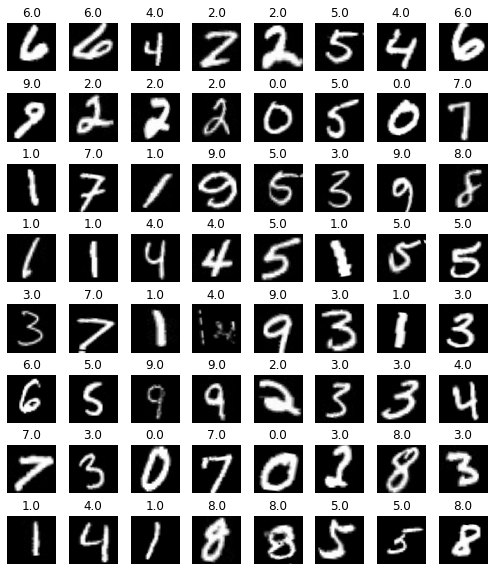

In [5]:
data.show_batch(rows=9, figsize=(7, 8))

In [6]:
data.classes

['0.0', '1.0', '10.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

In [7]:
data

ImageDataBunch;

Train: LabelList (56705 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1.0,1.0,1.0,1.0,1.0
Path: dataset;

Valid: LabelList (14176 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
5.0,8.0,6.0,9.0,1.0
Path: dataset;

Test: None

In [ ]:
# Learning

In [8]:
# fastai 1.0
from fastai import *
from torchvision.models import *    # import *=all the models from torchvision  

CROP_SIZE = 28
arch = resnet50                  # specify model architecture, densenet169 seems to perform well for this data but you could experiment
BATCH_SIZE = 128                    # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = CROP_SIZE                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'



In [10]:


# This will create an export.pkl file that you'll need to copy with your model file if you want to deploy it on another device.
# This saves the internal information (classes, etc) need for inference in a file named 'export.pkl'. 
#imgDataBunch.export(fname='./export.pkl')



In [9]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return cnn_learner(data, 
                      arch,
                      pretrained=True,
                      path='.', 
                      metrics=accuracy, 
                      ps=0.5, 
                      callback_fns=ShowGraph)

learner = getLearner()

In [13]:
# We can use lr_find with different weight decays and record all losses so that we can plot them on the same graph
# Number of iterations is by default 100, but at this low number of itrations, there might be too much variance
# from random sampling that makes it difficult to compare WD's. I recommend using an iteration count of at least 300 for more consistent results.
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')

learner = getLearner() #reset learner - this gets more consistent starting conditions


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [17]:
# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')

learner = getLearner() #reset learner - this gets more consistent starting conditions

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [18]:
# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


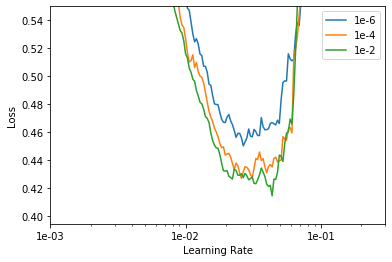

In [19]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [10]:
#learner.model = model.cuda()
learner.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

epoch,train_loss,valid_loss,accuracy,time
0,0.123361,0.165445,0.956969,05:52
1,0.126969,0.060307,0.983352,05:48
2,0.096059,0.189556,0.962119,05:47
3,0.077427,0.061193,0.986033,05:46
4,0.060467,0.051545,0.986033,05:46
5,0.034258,0.069127,0.993933,05:45
6,0.022036,0.017831,0.995203,05:45
7,0.020030,0.016437,0.995203,05:45


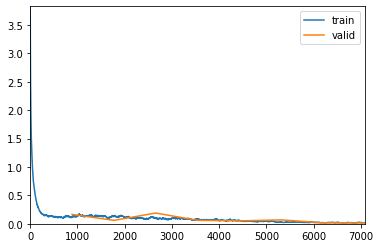

In [11]:
max_lr = 1.5e-02
wd = 1e-2
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

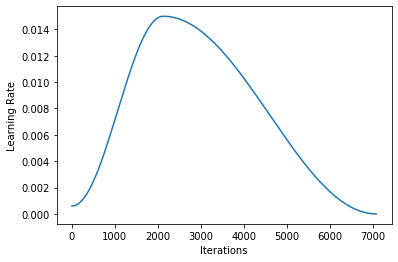

In [12]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

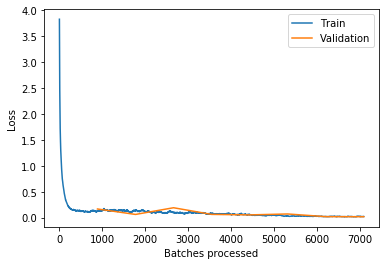

In [13]:
# and plot the losses of the first cycle
learner.recorder.plot_losses()

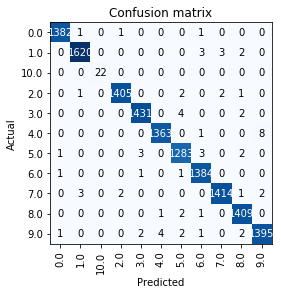

In [14]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [15]:
print(MODEL_PATH)

resnet50


In [16]:
# before we continue, lets save the model at this stage
learner.save(MODEL_PATH + '_stage1')

In [ ]:
# Validation



In [17]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))


The accuracy is 0.9952031373977661 %.


In [26]:
# I modified this from the fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

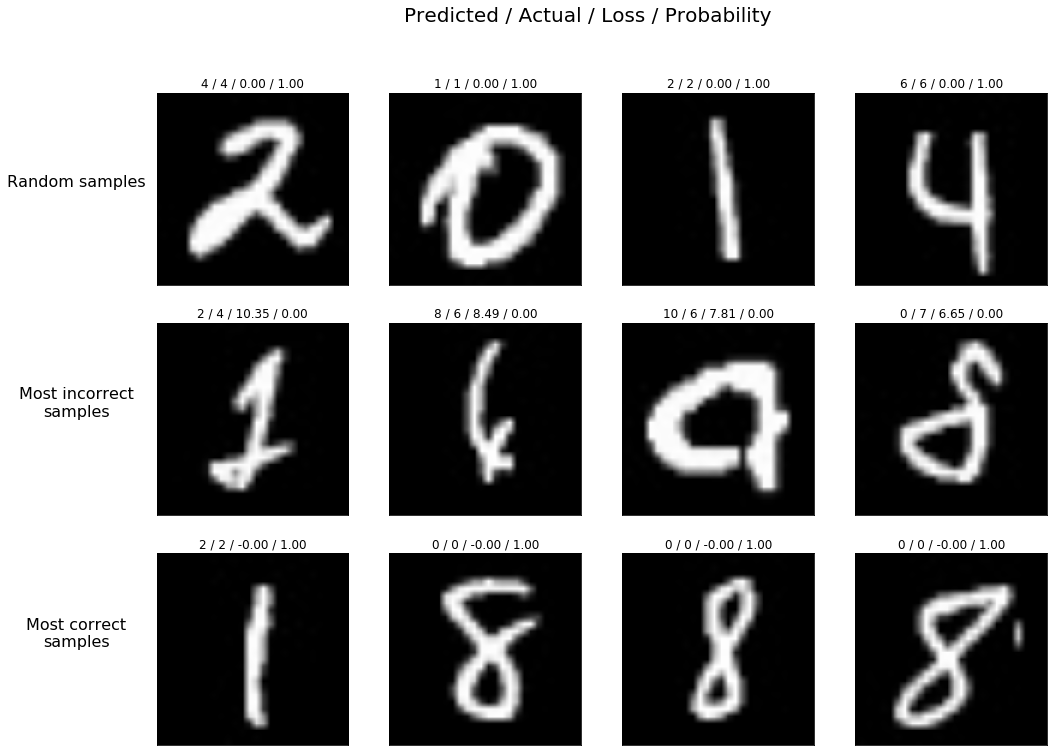

In [27]:
#interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, labels)

In [35]:
from fastai.callbacks.hooks import *
from fastai.vision import *


# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [43]:
# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = data.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = data.one_item(tensorImg)
    oneBatch_im = vision.Image(data.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

In [37]:
# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

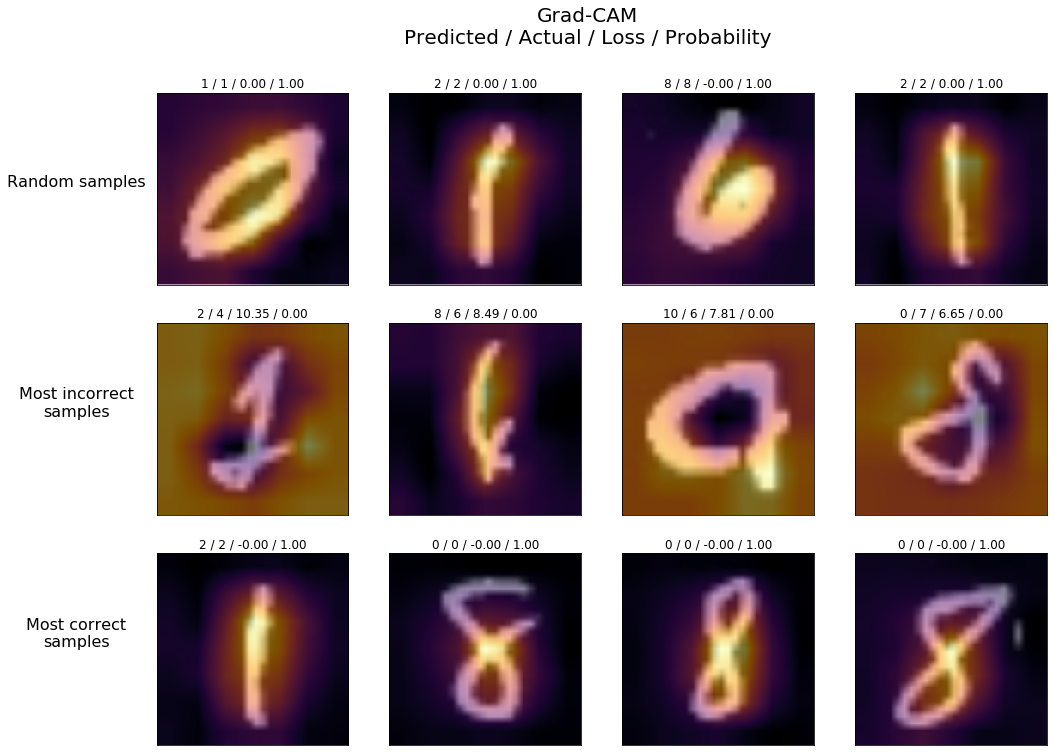

In [63]:
plot_heatmap_overview(interp, labels)

In [ ]:
# ROC Curves

In [45]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9999854612342658


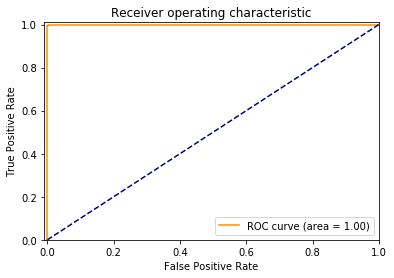

In [46]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")


In [52]:
# Export
# This will create an export.pkl file that you'll need to copy with your model file if you want to deploy it on another device.
# This saves the internal information (classes, etc) need for inference in a file named 'export.pkl'. 
data.export('./export.pkl')


In [60]:
%mv "dataset/export.pkl" "models/"

In [62]:
%ls models

export.pkl  resnet50_stage1.pth  tmp.pth


In [ ]:
######## RUN THIS ON A NEW MACHINE ##########
from fastai.vision import * # fastai 1.0
from fastai import *
from torchvision.models import *
arch = densenet169       # specify model architecture
MODEL_PATH = str(arch).split()[1] + '_stage2'
empty_data = ImageDataBunch.load_empty('./') #this will look for a file named export.pkl in the specified path
    learner = create_cnn(empty_data, arch).load(MODEL_PATH)